In [ ]:
import numpy as np
import os
import pandas as pd
from six.moves import cPickle
import pydicom
from matplotlib import pyplot as plt
import cv2
from os import listdir

In [ ]:
pip install pydicom

     |████████████████████████████████| 2.0 MB 2.4 MB/s 


###Test USC Loading Pipeline with one image (ASIF01/5024)

In [ ]:
test_path = "/content/drive/MyDrive/csb185_boneAge/data_usc_atlas/DICOM/ASIF/ASIF01/5024.dcm"
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path += '/content/drive/MyDrive/csb185_boneAge'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/content/drive/MyDrive/csb185_boneAge/data_usc_atlas/JPEGimages/ASIF/ASIF01/5024.jpg
<class 'numpy.ndarray'>
(299, 299, 3)


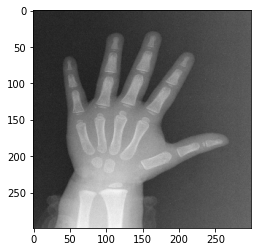

In [ ]:
img_dir =  "/content/drive/MyDrive/csb185_boneAge/data_usc_atlas/JPEGimages/ASIF/ASIF01/5024.jpg"


img_dir2 = test_path.replace("DICOM","JPEGimages")
img_new = img_dir2.replace("dcm","jpg")
print(img_new)

img = cv2.imread(img_new)
new_bone = cv2.resize(img, dsize = (299,299), interpolation = cv2.INTER_CUBIC)
#new_bone = np.array(new_bone, dtype = np.float32)



#replace DICOM with JPEGimages 
#replace dcm with jpg

#under ASIF01 theres 5004, 5024, 6114, 6127, 6141
print(type(new_bone))
print(new_bone.shape)
plt.imshow(new_bone)

In [ ]:
med_img = pydicom.read_file(test_path)
print(med_img)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.1.50327717011654183633130789380048403576
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.9590.100.1.0.100.4.0
(0002, 0013) Implementation Version Name         SH: 'IPI LAB 4.0'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: ['', 'ISO 2022 IR 87', 'ISO 2022 IR 13']
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9590.100.1.1.50327717011654183633130789380048403576
(0008, 0020) Study Date                         

In [ ]:
print(med_img.PatientID)
print(med_img.StudyDate)
print(med_img.PatientBirthDate)

84115024
20000308
19980504


In [ ]:
img = med_img.pixel_array
print(img.shape)
print(type(img))

(1425, 1153)
<class 'numpy.ndarray'>


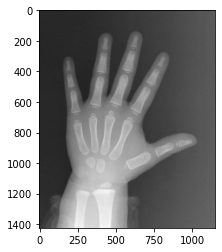

In [ ]:
plt.imshow(img,cmap = 'gray')

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array

In [ ]:
newimg = img_to_array(img)
print(newimg.shape)
newimg= newimg/255
#plt.imshow(np.uint8(newimg), cmap='gray')
#plt.imshow(newimg, cmap='gray')

(1425, 1153, 1)


In [ ]:
new_bone = img.copy()
new_bone = cv2.resize(img, dsize = (300,300), interpolation = cv2.INTER_CUBIC)
new_bone = np.array(new_bone, dtype = np.float32)


new_bone_3 = new_bone[:,:,np.newaxis]
new_bone_3 = new_bone_3 / 255

c3_skel = np.zeros_like(new_bone_3)
c3_skel[:,:,0] = np.squeeze(new_bone_3)
c3_skel[:,:,1] = new_bone_3
c3_skel[:,:,2] = new_bone_3
plt.imshow(c3_skel)

print(new_bone.shape)
print(new_bone_3.shape)
plt.imshow(new_bone_3)

IndexError: ignored

###Read USC images & Encode by folder names

In [ ]:
#their csv file had id#, boneage,male or female
#our dataset needs to have id#, boneage, male or female, and ethnicity

In [ ]:
print(len(X_train))

1391


In [ ]:
file_dir = '/content/drive/MyDrive/csb185_boneAge/data_usc_atlas/DICOM'
X_train = []
y_age = []
y_gender = []
y_ethnicity = []
#the window is supposed to be for dicom images in order to focus on the bone
# i applied this transformation to the images and it looked like the bones were a little clearer
#but we can play around and decide if we want to add this extra preprocessing step


def apply_window(img,center,width):
    image = img.copy()
    min_value = center - width // 2
    max_value = center + width // 2
    image[image < min_value] = min_value
    image[image > max_value] = max_value
    return image

def compute_bone_age(birthdate,studydate):
    year_of_birth = int(birthdate[0:4])
    year_of_study = int(studydate[0:4])
    #right now just making the simplification of using years because doing months gets complicated
    age = (year_of_study - year_of_birth) *12
    if (age <= 0):
        birthmonth = int(birthdate[4:6])
        month_of_study = int(studydate[4:6])
        age = month_of_study - birthmonth
    if(age == 0):
        age = 0
    return age

One_Hot_Encoding_Ethnicity = {'ASI': [1,0,0,0], 'BLK': [0,1,0,0], 'CAU' : [0,0,1,0], 'HIS' : [0,0,0,1], 'M': 1, 'F': 0}

for i in range(len(listdir(file_dir))):
    if listdir(file_dir)[i][0].isupper():
        spec_path = os.path.join(file_dir,listdir(file_dir)[i])
        ethnicity = listdir(file_dir)[i][0:3]
        encoded_ethnicity = One_Hot_Encoding_Ethnicity[ethnicity]
        gender = listdir(file_dir)[i][3]
        encoded_gender = One_Hot_Encoding_Ethnicity[gender]
        if(os.path.isdir(spec_path)):
            for j in range(len(listdir(spec_path))):
                if listdir(spec_path)[j][0].isupper():
                    npath =  os.path.join(spec_path,listdir(spec_path)[j])
                    if(os.path.isdir(npath)):
                        for k in range(len(listdir(npath))):
                            dcmpath = os.path.join(npath,listdir(npath)[k])
                            imgpath = dcmpath.replace("DICOM","JPEGimages")
                            img_path2 = imgpath.replace("dcm","jpg")
                            img_path3 = imgpath.replace("DCM","jpg")
                            if os.path.isfile(img_path2):
                                 img = cv2.imread(img_path2)
                            if os.path.isfile(img_path3):
                                img = cv2.imread(img_path3)
                            new_bone = cv2.resize(img, dsize = (299,299), interpolation = cv2.INTER_CUBIC)
                            #if os.path.isfile(dcmpath):
                            med_img = pydicom.read_file(dcmpath)
                            #bone_img = apply_window(img,3000,3000)
                            X_train.append(new_bone)
                            age = compute_bone_age(med_img.PatientBirthDate,med_img.StudyDate)   
                            y_age.append(age)
                            y_ethnicity.append(encoded_ethnicity)
                            y_gender.append(encoded_gender)                 

In [ ]:
print(len(X_train))
print(len(y_age))
print(len(y_ethnicity))
print(len(y_gender))

1391
1391
1391
1391


(299, 299, 3)

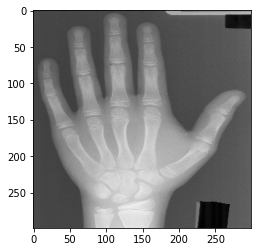

In [ ]:
plt.imshow(X_train[50])
X_train[7].shape

In [ ]:
#Save Data
train_pkl = open('data.pkl','wb')
cPickle.dump(X_train, train_pkl, protocol=cPickle.HIGHEST_PROTOCOL)
train_pkl.close()

train_age_pkl = open('data_age.pkl','wb')
cPickle.dump(y_age, train_age_pkl, protocol=cPickle.HIGHEST_PROTOCOL)
train_age_pkl.close()

train_gender_pkl = open('data_gender.pkl','wb')
cPickle.dump(y_gender, train_gender_pkl, protocol=cPickle.HIGHEST_PROTOCOL)
train_gender_pkl.close()

train_ethnicity_pkl = open('data_ethnicity.pkl','wb')
cPickle.dump(y_ethnicity, train_ethnicity_pkl, protocol=cPickle.HIGHEST_PROTOCOL)
train_ethnicity_pkl.close()  

Trouble opening the .pkl file --> one answer on stack overflow said that its possibly because of an autogenerated .DS_Store file, which I thought i removed with the is_upper statements in the file loader but I still need to play around with it

# Localization

In [ ]:
#dependency
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
import tensorflow
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.layers import Flatten, Dense, Input, Reshape, Lambda
from keras import backend as K
from keras import optimizers

os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ['OMP_NUM_THREADS']='6'
batch_size = 32
epochs = 30

In [ ]:
pip install visualization

     |████████████████████████████████| 1.2 MB 3.2 MB/s 
     |████████████████████████████████| 640 kB 46.9 MB/s 
     |████████████████████████████████| 116 kB 57.5 MB/s 
     |████████████████████████████████| 109 kB 58.3 MB/s 
     |████████████████████████████████| 2.2 MB 38.3 MB/s 
     |████████████████████████████████| 890 kB 40.2 MB/s 
     |████████████████████████████████| 546 kB 65.2 MB/s 
     |████████████████████████████████| 994 kB 47.3 MB/s 
     |████████████████████████████████| 212 kB 52.2 MB/s 
     |████████████████████████████████| 107 kB 51.7 MB/s 
  Created wheel for PyOpenGL: filename=PyOpenGL-3.1.0-py3-none-any.whl size=1745210 sha256=d4f8a570f570c7dcb2ccee08dd7d5ec86309de1d81cb570b07d4d9f4b75915ff
  Stored in directory: /root/.cache/pip/wheels/c6/83/cb/af51a0c06c33d08537b941bbfc87469e8a3c68d05f77a6a212
  Created wheel for pycollada: filename=pycollada-0.7.2-py3-none-any.whl size=127028 sha256=365f57931414328fc68ffcfa7336383c3b4ad2df09a6105c41c475c4c5c2459b
 

In [ ]:
%cd /content/drive/MyDrive/csb185_boneAge
from func_utils import *

/content/drive/.shortcut-targets-by-id/1QGTllN27TLcWAEKVbjfl8-M8-E6HzAO8/csb185_boneAge



per the paper i don't think the gender/ethnicity info is needed for this part, the code is there probably when testing the inceptionv3 as one of the baseline models?


In [ ]:
# Load data
f = open(root_dir+'data_age.pkl', 'rb')
y = pickle.load(f)
f.close()

print('...loading training data')
f = open(root_dir+'data.pkl', 'rb')
x = pickle.load(f)
f.close()

#not needed?
f = open(root_dir+'data_gender.pkl','rb')
gender = pickle.load(f)
f.close()

In [ ]:
#convert to array
x = np.asarray(x, dtype=np.float32) 
y = np.asarray(y)
#not needed?
#gender = np.asarray(gender)

x /= 255.
x_final = []
y_final = []
#not needed?
#gender =2*( gender-0.5) #1, 0 -> 1, -1 M, F
#gender_final = []

In [ ]:
print('sample size: ', x.shape, ' age size: ', y.shape)

sample size:  (1391, 299, 299, 3)  age size:  (1391,)


In [ ]:
# Shuffle images and split into train, validation and test sets
# skip gender part
random_no = np.arange(x.shape[0])
np.random.seed(0)
np.random.shuffle(random_no)
for i in random_no:
    x_final.append(x[i,:,:,:])
    y_final.append(y[i])
    #gender_final.append(gender[i])

x_final = np.asarray(x_final)
y_final = np.asarray(y_final)
#gender_final = np.asarray(gender_final)

k = 55 # Decides split count based on 500:12611 of the original RSNA 
x_test = x_final[:k,:,:,:]
y_test = y_final[:k]
#gender_test = gender_final[:k]

x_valid = x_final[k:2*k,:,:,:]
y_valid = y_final[k:2*k]
#gender_valid = gender_final[k:2*k]

x_train = x_final[2*k:,:,:,:]
y_train = y_final[2*k:]
#gender_train = gender_final[2*k:]

#y_test = keras.utils.to_categorical(y_test,240)
#y_train = keras.utils.to_categorical(y_train,240)
#y_valid = keras.utils.to_categorical(y_valid,240)
y_train = softlabel(y_train,240) #see func utils
y_valid = softlabel(y_valid,240)
y_test = softlabel(y_test,240)
print (y_train[0,:])

[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.02 0.04 0.06 0.08 0.1
 0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28 0.3  0.32 0.34 0.36 0.38
 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54 0.56 0.58 0.6  0.62 0.64 0.66
 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82 0.84 0.86 0.88 0.9  0.92 0.94
 0.96 0.98 1.   0.98 0.96 0.94 0.92 0.9  0.88 0.86 0.84 0.82 0.8  0.78
 0.76 0.74 0.72 0.7  0.68 0.66 0.64 0.62 0.6  0.58 0.56 0.54 0.52 0.5
 0.48 0.46 0.44 0.42 0.4  0.38 0.36 0.34 0.32 0.3  0.28 0.26 0.24 0.22
 0.2  0.18 0.16 0.14 0

In [ ]:
print ('x_train shape:'+ str(x_train.shape))
print ('y_train shape:'+ str(y_train.shape))
#print ('gender_train shape:'+ str(gender_train.shape))
print ('x_valid shape:'+ str(x_valid.shape))
print ('y_valid shape:'+ str(y_valid.shape))
#print ('gender_valid shape:' + str(gender_valid.shape))
print ('x_test shape:'+ str(x_test.shape))
print ('y_test shape:'+ str(y_test.shape))

x_train shape:(1281, 299, 299, 3)
y_train shape:(1281, 240)
x_valid shape:(55, 299, 299, 3)
y_valid shape:(55, 240)
x_test shape:(55, 299, 299, 3)
y_test shape:(55, 240)


In [ ]:
# Using VGG19 with pretrained weights from Imagenet 
base_model = InceptionV3(weights='imagenet', include_top=False)
for i,layer in enumerate(base_model.layers):
    print (i,layer.name)

#originally 300x300 but the usc is loaded as 299 299 so i change the input shape
input = Input(shape=(299,299,3),name='input1')

#input_gender = Input(shape=(1,),dtype='float32',name='input2')
output = base_model(input)
#gender_embedding=Dense(16)(input_gender)
#gender_embedding=Dense(12)(gender_embedding)
#x = keras.layers.MaxPooling2D(pool_size=(3,3))(output)
#x = keras.layers.Conv2D(512,kernel_size=(3,3))(x)
#x = keras.layers.Conv2D(256,kernel_size=(1,1))(x)
print (K.int_shape(output))
x = keras.layers.MaxPooling2D(pool_size=(8,8))(output)
print (K.int_shape(x))
x = Flatten()(x)
#f = keras.layers.Concatenate(axis=1)([x,gender_embedding])
#print (K.int_shape(f)) 
#x = Dense(256, activation='relu')(x)
predictions = Dense(240)(x)

0 input_3
1 conv2d_188
2 batch_normalization_188
3 activation_188
4 conv2d_189
5 batch_normalization_189
6 activation_189
7 conv2d_190
8 batch_normalization_190
9 activation_190
10 max_pooling2d_10
11 conv2d_191
12 batch_normalization_191
13 activation_191
14 conv2d_192
15 batch_normalization_192
16 activation_192
17 max_pooling2d_11
18 conv2d_196
19 batch_normalization_196
20 activation_196
21 conv2d_194
22 conv2d_197
23 batch_normalization_194
24 batch_normalization_197
25 activation_194
26 activation_197
27 average_pooling2d_18
28 conv2d_193
29 conv2d_195
30 conv2d_198
31 conv2d_199
32 batch_normalization_193
33 batch_normalization_195
34 batch_normalization_198
35 batch_normalization_199
36 activation_193
37 activation_195
38 activation_198
39 activation_199
40 mixed0
41 conv2d_203
42 batch_normalization_203
43 activation_203
44 conv2d_201
45 conv2d_204
46 batch_normalization_201
47 batch_normalization_204
48 activation_201
49 activation_204
50 average_pooling2d_19
51 conv2d_200
52

In [ ]:
model = Model(inputs=[input], outputs=predictions)
for i,layer in enumerate(model.layers):
    print(i,layer.name)

Adam = tensorflow.keras.optimizers.Adam(learning_rate=0.0003,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])



0 input1
1 inception_v3
2 max_pooling2d_9
3 flatten_1
4 dense


the model is run thru 60 epochs with lr=0.0003 and then 30 epochs with lr = 0.0001 

In [ ]:
# Save weights after every epoch 
#the weights folder needs to be created before training
checkpoint = keras.callbacks.ModelCheckpoint(filepath=root_dir+'weights/weights.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True)
history=model.fit([x_train],y_train,batch_size=batch_size,epochs=60,verbose=1,validation_data=([x_valid],y_valid), callbacks = [checkpoint])
score = model.evaluate([x_test], y_test, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

#TestMAE = TestMAE(model,x_test,y_test,gender_test)
#print ('TestMAE:',TestMAE)
##Visulization
weights = model.layers[-1].get_weights()[0]
print(weights.shape)

#checked that it runs but it's probably reading from my previous weights folder

Epoch 1/60
 1/41 [..............................] - ETA: 15:32 - loss: 2.8983 - MAE: 2.8983

In [ ]:

#for layer in base_model.layers[:16]:
#    layer.trainable=False
#for layer in base_model.layers:
#    print (layer.name,layer.trainable)
Adam = tensorflow.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.9, beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])
history = model.fit([x_train],y_train,batch_size=batch_size,epochs=30,verbose=1,validation_data=([x_valid],y_valid), callbacks = [checkpoint])
score = model.evaluate([x_test], y_test, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

#TestMAE = TestMAE(model,x_test,y_test,gender_test)
#print ('TestMAE:',TestMAE)

weights = model.layers[-1].get_weights()[0]
print (weights.shape)


In [ ]:
#weights are saved in model.h5, training history in history pkl
model.save_weights(os.path.join(root_dir,"model.h5"))
with open(os.path.join(root_dir,'history.pkl'), 'wb') as f:
	pickle.dump(history.history, f)
f.close()


In [ ]:
#code to load weights in case before cropping runtime disconn
model.load_weights(os.path.join(root_dir,"model.h5"))
weights = model.layers[-1].get_weights()[0]
print(weights.shape)#2048240

#crop

In [ ]:
#the func for generating heatmaps and attention imgs, set your own paths
def GAPAttention(model,weights,image_path):
    file_list = os.listdir(image_path)
    file_list.sort()
    for filename in file_list:
        filepath=image_path+filename
        print(filepath)
        image=load_image(filepath)
        image = image/255.0
        gender=1.0
        gender=np.asarray(gender)
        gender=np.expand_dims(gender,axis=0)
        #backend.function(input, output, update=None): Taking input from the first parameter 
        #and extracting the number of outputs as per the layers mentioned in the second parameter
        layer=K.function([model.layers[0].input], [model.layers[1].get_output_at(-1), model.layers[-1].output])
        print(model.layers[0].input.shape)
        #Model(inputs=[input,input_gender]) 
        GAP,prediction=layer([image,gender])
        GAP=np.squeeze(GAP,axis=0)
        print(GAP.shape)
        index = np.argmax(prediction)
        print(index)
        #weight = weights[:,index]
        weight =np.mean(weights[:,index-5:index+5],axis=1)
        heatmap = np.zeros((GAP.shape[0],GAP.shape[1]))
        for k in range(GAP.shape[2]):
            heatmap = heatmap + weight[k]*GAP[:,:,k]
        heatmap = heatmap/np.max(heatmap)
        heatmap = np.uint8(255*heatmap)
        #print(heatmap.shape)
        heatmap = cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)
        SaveImg(filename,filepath,heatmap)
    print ('********** Done ***********')

def SaveImg(filename,filepath,heatmap):
    img = cv2.imread(filepath)
    heatmap = cv2.resize(heatmap,(img.shape[1],img.shape[0]))
    AttentionImg =0.5* heatmap + img
    #in case file paths mess up
    if not cv2.imwrite(os.path.join('/content/drive/MyDrive/heatmap',filename),heatmap):
       raise Exception("Could not write heatmap")
    if not cv2.imwrite(os.path.join('/content/drive/MyDrive/AttentionImg',filename),AttentionImg):
       raise Exception("Could not write AttentionImg")
#for hand
GAPAttention(model,weights, t_dir)
#this for v1
#ShowAttentionV1(base_model, t_dir)

In [ ]:
#size check
print(len(os.listdir(t_dir)))
print(len(os.listdir('/content/drive/MyDrive/heatmap')))
print(len(os.listdir('/content/drive/MyDrive/AttentionImg')))

In [ ]:
def crop(img,mask):
    index = np.where(mask>0)
    top =np.min(index[0])
    bottom = np.max(index[0]) 
    left = np.min(index[1])
    right = np.max((index[1]))
   # extract hand region
   # if top > 200:
   #     top =top -200
   # elif top > 100:
   #     top = top -100

   # extract region1
   # if left>100:
   #     left=left-70

    croped_img = img[top:bottom,left:right]
    return croped_img


#this for creating the r1erased img, not needed
def maskout(img,mask):
    index = np.where(mask>0)
    top =np.min(index[0])
    bottom = np.max(index[0]) 
    left = np.min(index[1])
    right = np.max((index[1]))
    img[top:bottom,left:right]=np.random.randint(255)
    return img


def find_max_component(mask):
    contours, hierarchy = cv2.findContours(mask,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
    area = []
    for i in range(len(contours)):
        area.append(cv2.contourArea(contours[i]))
    try:
       max_ind = np.argmax(area)
    except ValueError: 
        print("Err")
        pass
    print (area)
    for ind in range(len(contours)):
        if ind != max_ind:
            cv2.fillConvexPoly(mask,contours[ind],0)
    return mask



#crop based on heatmap, saved to hand floder
#for the threhold,
# if it's set to 20 then it basically crops something similar to V1
# the original code has it set to 40
if __name__=="__main__":
    errimg = []
    path_list = os.listdir('/content/drive/MyDrive/heatmap/')
    path_list.sort()
    kernel = np.ones((5,5),np.uint8)
    for path in path_list:
      if path.endswith('png'):
          img = cv2.imread(os.path.join(t_dir,path),0)
      try:
          heatmap = cv2.imread(os.path.join('/content/drive/MyDrive/heatmap/',path),0)
          
          ret,mask =  cv2.threshold(heatmap,40,255,cv2.THRESH_BINARY)
          mask = find_max_component(mask)
                # mask = cv2.dilate(mask,kernel,iterations=1)
                # cv2.imwrite('patches/'+path,mask)
                # img = img*mask
                # cv2.imwrite('patches/'+path,img)
          croped_img= crop(img,mask)
          if not cv2.imwrite(os.path.join('/content/drive/MyDrive/Hand/',path),croped_img):
                print("Exception: fail to write img " + path)
      except ValueError: 
          errimg.append(path)
          pass
          ##for deriving v2 
          #MaskImg = maskout(img,mask)
          #cv2.imwrite('Maskout/'+path,MaskImg)

the output hand images have the same file names as the original, so in the regression part the loading should be the same. i don't think the regression part is using the aggregate.py where different types of patches are feed into multipul input channels, so just save the localized hand images as pkl and load in future as the input

#Getting Datasets Ready to Train (Modified based on Original code)

In [ ]:
#data = np.asarray(X_train, dtype = np.float32)
print(type(X_train))

NameError: ignored

In [ ]:
data = np.array(X_train, dtype = np.float32)
data /=255

NameError: ignored

In [ ]:
print(data.shape)

NameError: ignored

In [ ]:
plt.imshow(data[1])

In [ ]:
age = np.array(y_age)
gender = np.asarray(y_gender)
ethnicity = np.array(y_ethnicity)
gender = 2*(gender-0.5)

x_final = []
y_final = []
gender_final = []
ethnicity_final = []

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import keras
#from func_utils import *
import os
from keras.applications.resnet import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.layers import Flatten, Dense, Input, Reshape, Lambda
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
os.environ["CUDA_VISIBLE_DEVICES"]="4"
os.environ['OMP_NUM_THREADS']='6'
batch_size = 16
epochs = 30

Shuffle Images and split into train, validation and test sets

In [ ]:
random_no = np.random.choice(data.shape[0], size = data.shape[0], replace = False)
#random_no = np.arange(x.shape[0])
np.random.seed(0)
np.random.shuffle(random_no)
for i in random_no:
    x_final.append(data[i,:,:,:])
    y_final.append(age[i])
    gender_final.append(gender[i])
    ethnicity_final.append(ethnicity[i])

In [ ]:
x_final = np.asarray(x_final)
y_final = np.asarray(y_final)
gender_final = np.asarray(gender_final)
ethnicity_final = np.asarray(ethnicity_final)

In [ ]:
x_final.shape

In [ ]:
k = 300
x_test = x_final[:k,:,:,:]
y_test = y_final[:k]
gender_test = gender_final[:k]
ethnicity_test = ethnicity_final[:k]
x_valid = x_final[k:2*k,:,:,:]
y_valid = y_final[k:2*k]
gender_valid = gender_final[k:2*k]
ethnicity_valid = ethnicity_final[k:2*k]
x_train = x_final[2*k:,:,:,:]
y_train = y_final[2*k:]
gender_train = gender_final[2*k:]
ethnicity_train = ethnicity_final[2*k:]

In [ ]:
plt.matshow(x_train[5])

In [ ]:
print ('x_train shape:'+ str(x_train.shape))
print ('y_train shape:'+ str(y_train.shape))
print ('gender_train shape:'+ str(gender_train.shape))
print('ethnicity_train shape:' + str(ethnicity_train.shape))
print ('x_valid shape:'+ str(x_valid.shape))
print ('y_valid shape:'+ str(y_valid.shape))
print ('gender_valid shape:' + str(gender_valid.shape))
print('ethnicity_valid shape:' + str(ethnicity_valid.shape))
print ('x_test shape:'+ str(x_test.shape))
print ('y_test shape:'+ str(y_test.shape))

#Using VGG19 with pretrained weights from Imagenet (Modified from original code)

In [ ]:
base_model = Xception(weights='imagenet',include_top=False)
for i,layer in enumerate(base_model.layers):
    print (i,layer.name)
input = Input(shape=(299,299,3),name='input1')
input_gender = Input(shape=(1,),name='input2')
input_ethnicity = Input(shape=(4,),name='input3')
output = base_model(input)
gender_embedding = Dense(32)(input_gender)
ethnicity_embedding = Dense(32)(input_ethnicity)
x = keras.layers.Conv2D(256,kernel_size=(3,3))(output)
print (K.int_shape(output))
x = keras.layers.MaxPooling2D(pool_size=(3,3))(x)
print (K.int_shape(x))
x=Flatten()(x)
f = keras.layers.Concatenate(axis = 1)([x,gender_embedding, ethnicity_embedding])
print(K.int_shape(f))
predictions = Dense(1)(f)

NameError: ignored

In [ ]:
model = Model(inputs = [input, input_gender, input_ethnicity], outputs = predictions)
for i,layer in enumerate(model.layers):
    print(i, layer.name)

NameError: ignored

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
#Adam=keras.optimizers.Adam(lr=0.0003,beta_1=0.9,beta_2=0.999)
#keras.optimizers.adam_v2(lr=0.0003,beta_1=0.9,beta_2=0.999)

Adam = Adam(learning_rate =0.0003,beta_1=0.9,beta_2=0.999)
model.compile(optimizer= Adam, loss='mean_absolute_error', metrics=['MAE'])

In [ ]:
def DataAugment(x_train):
    x_train_Aug = np.zeros(x_train.shape)
    for i in range(x_train.shape[0]):
        for j in range(3):
            img = x_train[i,:,:,j]
            img = RandomMask(img)
            img = RandomMask(img)
            if np.random.random()>-1:
                x_train_Aug[i,:,:,j]=img 
            else:
                x_train_Aug[i,:,:,j]=x_train[i,:,:,j]
    return x_train_Aug


def RandomMask(img):
    m,n=img.shape
    m=int(m/6)
    n=int(n/6)
    i,j = np.random.randint(0,6,2)
    img[i*m:(i+1)*m,j*n:(j+1)*n]=np.random.random()
    return img

In [ ]:
DataGen = ImageDataGenerator(rotation_range=20,width_shift_range=0.15,height_shift_range=0.15,zoom_range=0.2,horizontal_flip=True)
def Generator(x_train,gender_train,ethnicity_train,y_train,batch_size):
    loopcount = len(y_train)//batch_size
    i=0
    while (True):
        if i>loopcount:
            i=0
        # i=np.random.randint(0,loopcount)
        x_train_batch = x_train[i*batch_size:(i+1)*batch_size,:,:]
        #x_train_batch = DataAugment(x_train_batch)
        gender_train_batch = gender_train[i*batch_size:(i+1)*batch_size]
        ethnicity_train_batch = ethnicity_train[i*batch_size:(i+1)*batch_size]
        y_train_batch = y_train[i*batch_size:(i+1)*batch_size]
        inputs = [x_train_batch,gender_train_batch,ethnicity_train_batch]
        target = y_train_batch
        yield (inputs ,target)
        i = i+1

In [ ]:
checkpoint =keras.callbacks.ModelCheckpoint(filepath='weights/weights.{epoch:02d}-{val_loss:.2f}.hdf5',save_weights_only=True,period=30)
#history = model.fit_generator(DataGen.flow([x_train,gender_train,ethnicity_train],y_train,batch_size=batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=350,verbose=1,validation_data=([x_valid,gender_valid,ethnicity_valid],y_valid))
#history = model.fit_generator(Generator(x_train,gender_train,y_train,batch_size),steps_per_epoch=np.ceil(len(y_train)/batch_size),epochs=10,verbose=1,validation_data=([x_valid,gender_valid],y_valid))
history=model.fit([x_train,gender_train,ethnicity_train],y_train,batch_size=batch_size,epochs=80,verbose=1,validation_data=([x_valid,gender_valid,ethnicity_valid],y_valid), callbacks = [checkpoint])
model.compile(optimizer= Adam, loss='mean_absolute_error', metrics=['MAE'])
score = model.evaluate([x_test,gender_test,ethnicity_test], y_test, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])

##Visulization
weights=model.layers[-1].get_weights()[0]
print (weights.shape)

#save this training 
model.save_weights('/content/drive/MyDrive/Colab/usc/'+"model_usc.h5")
with open('/content/drive/MyDrive/Colab/usc/'+'history.pkl', 'wb') as f:
	pickle.dump(history.history, f)
f.close()

In [ ]:
# Continue training age regression (2nd)
from tensorflow.keras.optimizers import Adam
Adam=Adam(learning_rate =0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])
print(model.output)

history = model.fit([x_train,gender_train,ethnicity_train], y_train,batch_size=batch_size,epochs=30,verbose=1,validation_data=([x_valid,gender_valid],y_valid), callbacks = [checkpoint])

#model.save_weights('/content/drive/MyDrive/Colab/usc/'+"model_usc.h5")
#with open('/content/drive/MyDrive/Colab/usc/'+'history.pkl', 'wb') as f:
#	pickle.dump(history.history, f) #history not defined???
#f.close()

score = model.evaluate([x_test,gender_test,ethnicity_test], y_test, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])
##Visulization
weights=model.layers[-1].get_weights()[0]
print (weights.shape)

In [ ]:
#@title


In [ ]:
#Continue training age regression with even smaller learning rate (3rd)
from tensorflow.keras.optimizers import Adam
Adam=Adam(lr=0.00001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=Adam, loss='mean_absolute_error', metrics=['MAE'])
print(model.output)

history = model.fit([x_train,gender_train,ethnicity_train], y_train,batch_size=batch_size,epochs=30,verbose=1,validation_data=([x_valid,gender_valid],y_valid), callbacks = [checkpoint])

#model.save_weights('/content/drive/MyDrive/Colab/usc/'+"model_usc.h5") #uncomment if you need to save


score = model.evaluate([x_test,gender_test,ethnicity_test], y_test, batch_size=batch_size)
print('Test loss:', score[0])
print('Test MAE:', score[1])
##Visulization
weights=model.layers[-1].get_weights()[0]
print (weights.shape)

In [ ]:
#Save everything about the trained regression model into a folder
model.save('/content/drive/MyDrive/Colab/usc/'+"model_usc_last120") #change DIRECTORY!!

#with open('/content/drive/MyDrive/Colab/usc/'+'history_usc.pkl', 'wb') as f:
#	pickle.dump(history.history, f)
#f.close()